In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns

### Feature Selection using hybrid approach ###

In [2]:
#https://github.com/comet-ml/comet-content/blob/master/home-credit/data/eda-part-1.ipynb
df = pd.read_csv('credit_date_df.csv', index_col=0)

In [3]:
#one-hot encoding
df = pd.get_dummies(df, columns = ['year', 'month','product_term_credit_limit'])

In [4]:
# integer valued features
integer_df = df.select_dtypes(include=['int'])
integer_df.drop(columns=['NP'], axis=1, inplace=True)

# some integer features are actually categorical features. So we need to extract these columns
binary_cols = [col for col in integer_df if (list(integer_df[col].unique()) == [0, 1]) or (list(integer_df[col].unique()) == [1, 0])]
integer_df.shape

(19030, 1490)

In [5]:
# float valued features
float_df = df.select_dtypes(exclude=['int', 'object'])
float_df.shape

(19030, 855)

In [6]:
# categorical features
categorical_df = df.select_dtypes(exclude=['int', 'float'])
categorical_df.shape

(19030, 19)

In [7]:
X_encoded = pd.concat([categorical_df, integer_df[binary_cols]], axis=1)

In [8]:
# pca transformation function
from sklearn.decomposition import PCA
from sklearn import preprocessing

def do_pca(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    X_normalized = min_max_scaler.fit_transform(df)

    pca = PCA(n_components=10)
    components = pca.fit_transform(X_normalized)
    columns = ['pca-{}'.format(i+1) for i in range(len(components[0,:]))]
    
    return (pca, pd.DataFrame(components, columns=columns))

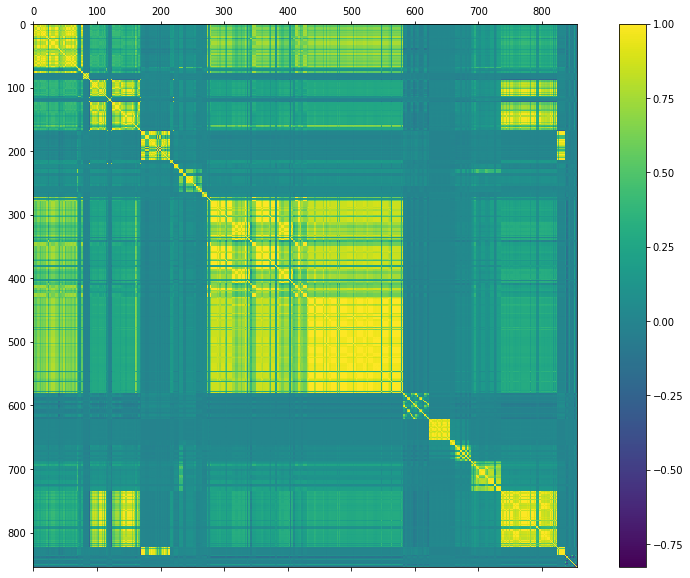

In [9]:
# plot correlation matrix for float type features
float_columns = list(float_df.columns)
float_corr = float_df.corr()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(float_corr, interpolation='nearest')
fig.colorbar(cax)

From the correlation graph, We see that features 280 to 590 are highly correlated, and on further inspection with data dictionary, we find that these features are all related to open/closed trades and unsatisfied medical collections. These features are good candidates for dimensionality reduction, since they are adding redundant information to the model.

In [10]:
# Select float features for pca transformation
pca_candidates = float_df.iloc[:, 280:590]
pca_candidates = pca_candidates.fillna(method='ffill')
pca_candidates = pca_candidates.fillna(method='bfill')
pca, X_pca = do_pca(pca_candidates)

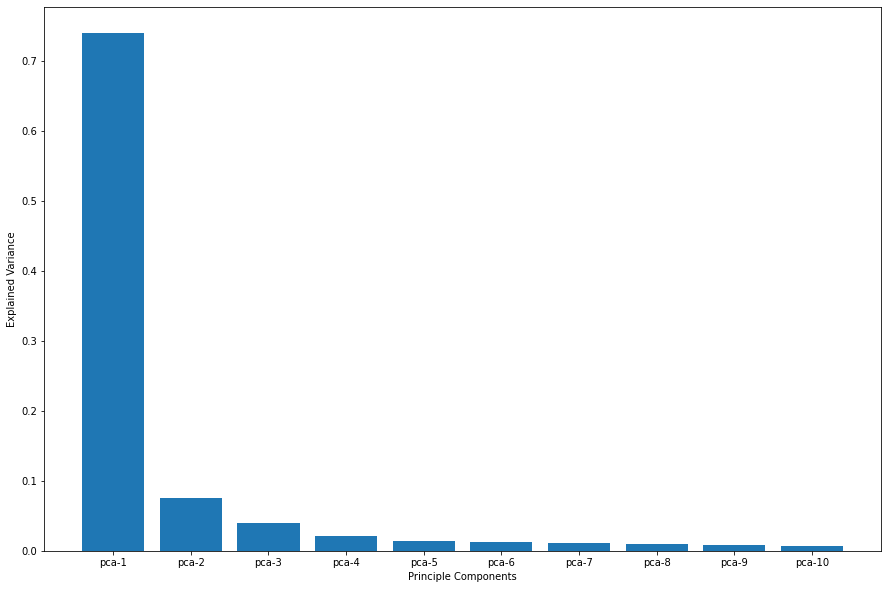

In [11]:
plt.figure(figsize=(15, 10))
plt.bar(X_pca.columns, pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Principle Components')
plt.show()

These 10 components are able to explain 70% of variance in the dataset and we can use these top 10 principle components in our dataset

In [12]:
# Drop pca candidate features from float_df
# Drop categorical features from integer_df
float_columns = list(float_df.columns)

float_df.drop(columns=float_columns[280:590], inplace=True, axis=1)
integer_df.drop(columns=binary_cols, inplace=True, axis=1)

integer_df.fillna(method='ffill', inplace=True)
float_df.fillna(method='ffill', inplace=True)
float_df.fillna(method='bfill', inplace=True)

In [15]:
y = df['NP']

In [16]:
from sklearn.ensemble import RandomForestClassifier
    
def rf_feature_plot(df, title):
    rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=31)
    rf.fit(df, y)

    features = list(df.columns)
    importances = rf.feature_importances_
    indices = np.argsort(importances).tolist()

    _tmp = indices[::-1][:15]
    _x = range(len(_tmp))

    feature_labels = [features[i] for i in _tmp]
    top_importance = [importances[i] for i in _tmp]

    plt.figure(figsize=(20,20))
    plt.barh(_x, top_importance[::-1], color='b', align='center')
    plt.yticks(_x, feature_labels[::-1], fontsize=14)
    plt.xlabel('Relative Importance')
    plt.show()

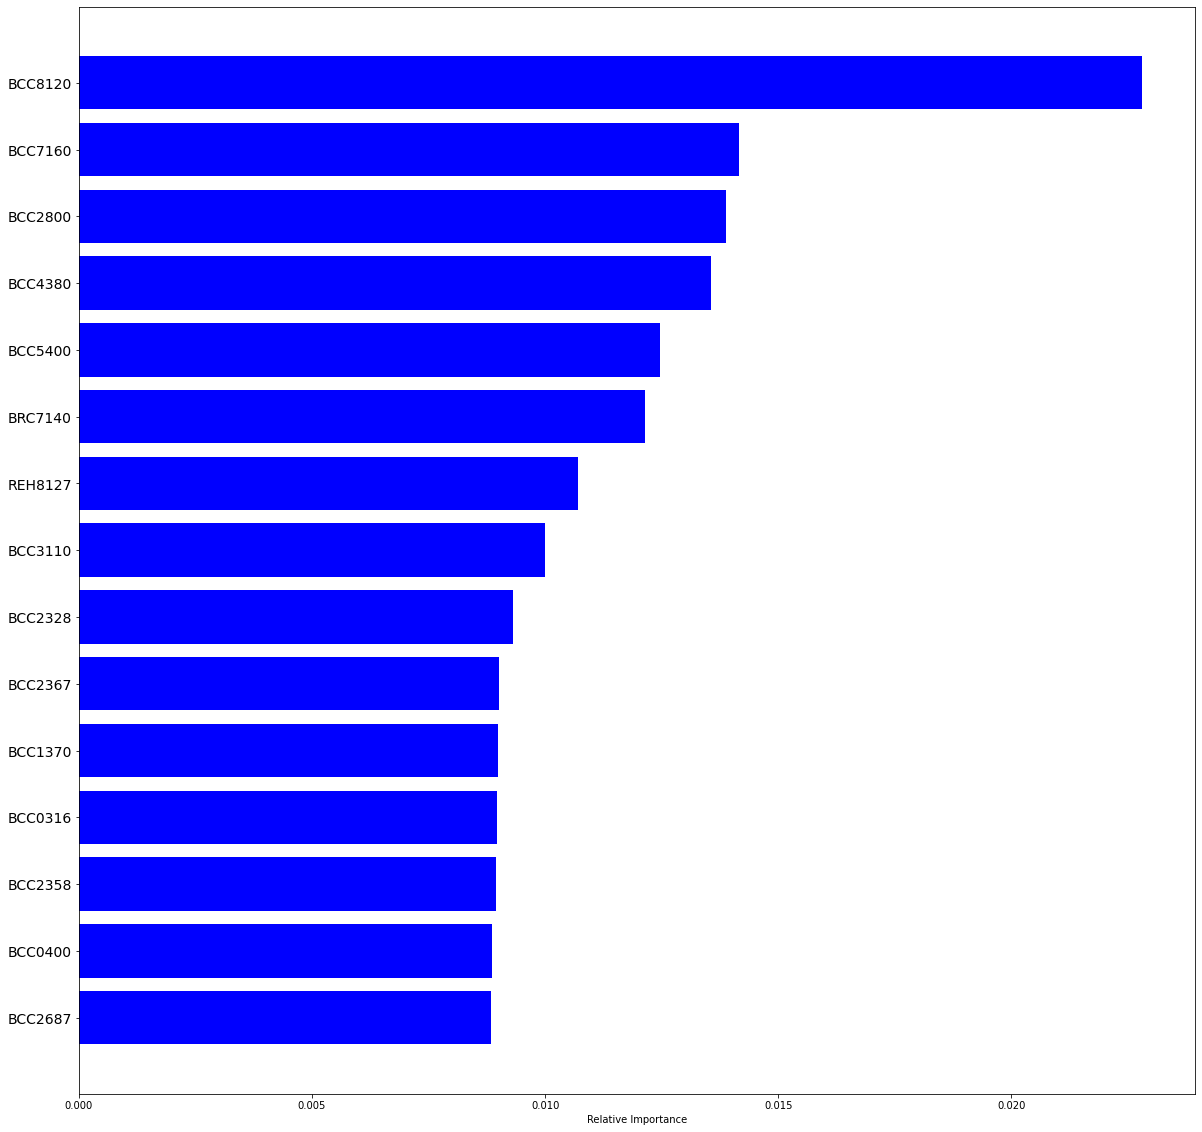

In [17]:
rf_feature_plot(integer_df, 'RF Integer Feature Importance')

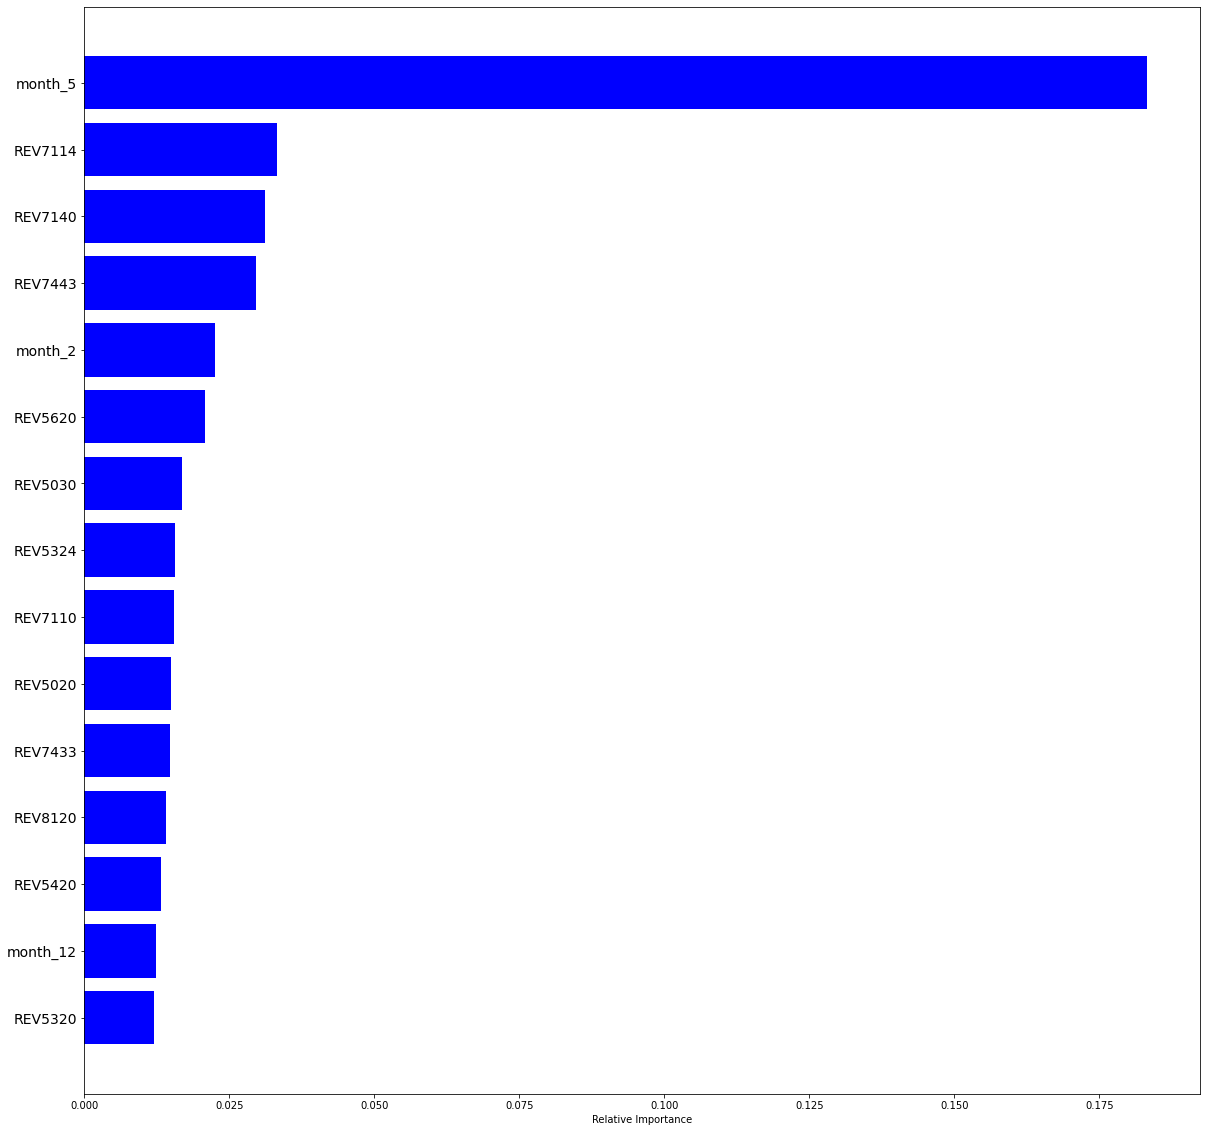

In [18]:
rf_feature_plot(float_df, 'RF Float Feature Importance')

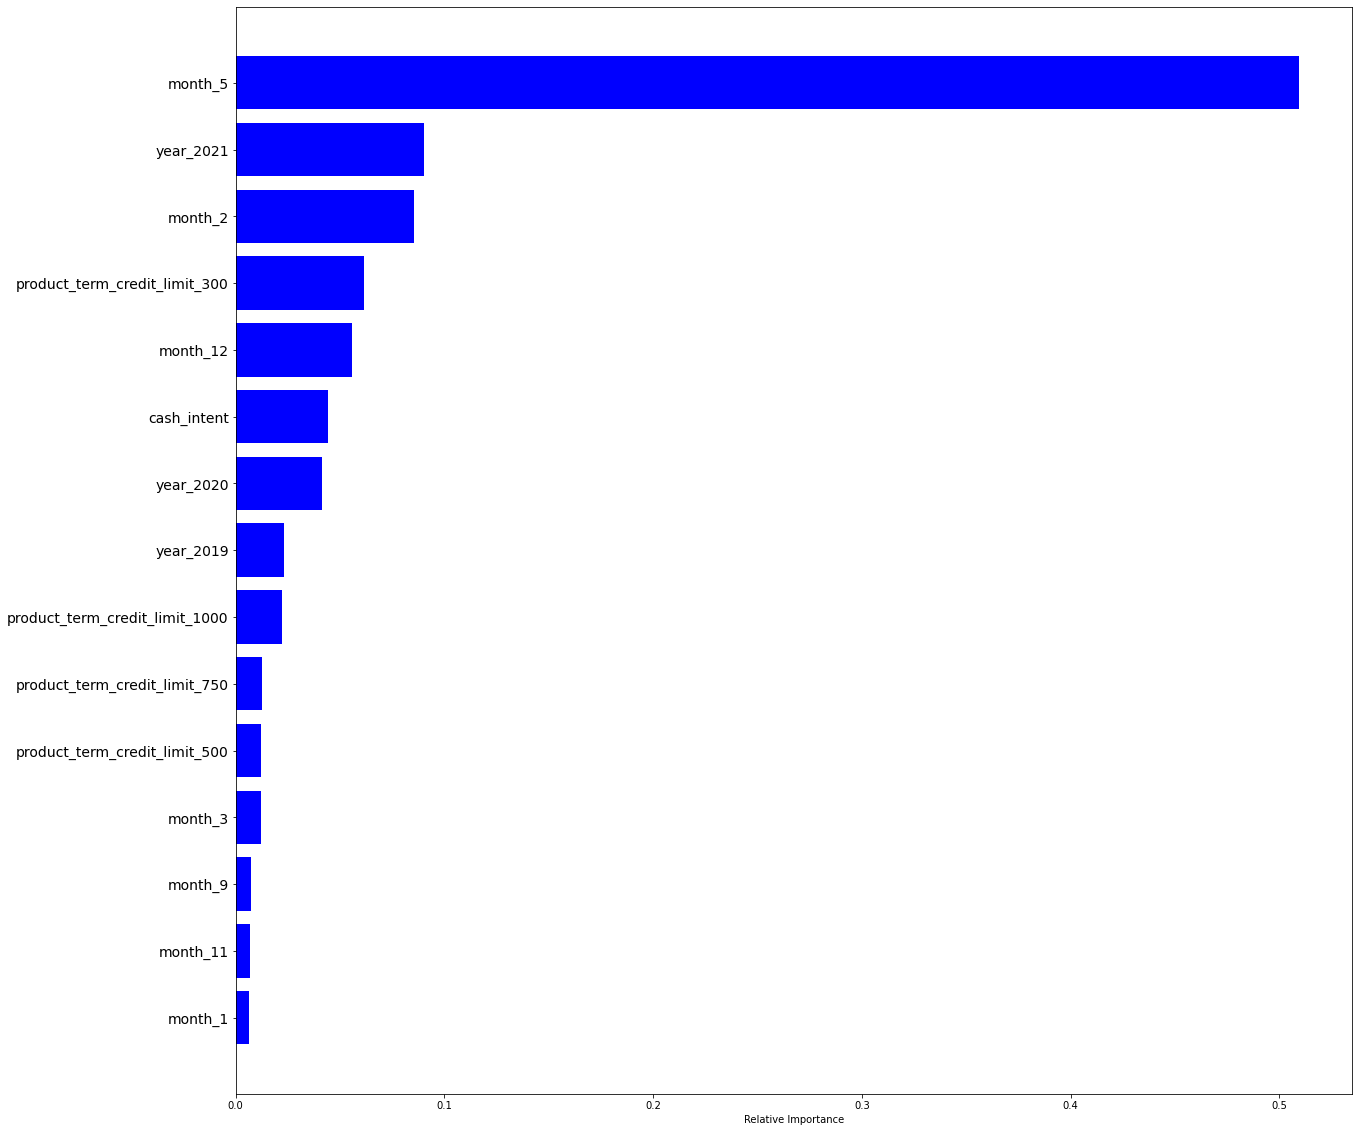

In [19]:
rf_feature_plot(X_encoded, 'RF Categorical Feature Importance')

In [20]:
#!pip install lightgbm

In [21]:
import lightgbm as lgb
import matplotlib.pyplot as plt

def lightgbm_feature_plot(df, y, title):
    train_data = lgb.Dataset(data=df, label=y, feature_name=list(df.columns))
    param = {'num_leaves':31, 'num_trees':100, 'objective':'binary', 'metric' : 'auc'}
    num_round = 10
    
    bst = lgb.train(param, train_data, num_round)
    ax = lgb.plot_importance(bst, max_num_features=15, figsize=(15, 10), height=0.5)

[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48309
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 542
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


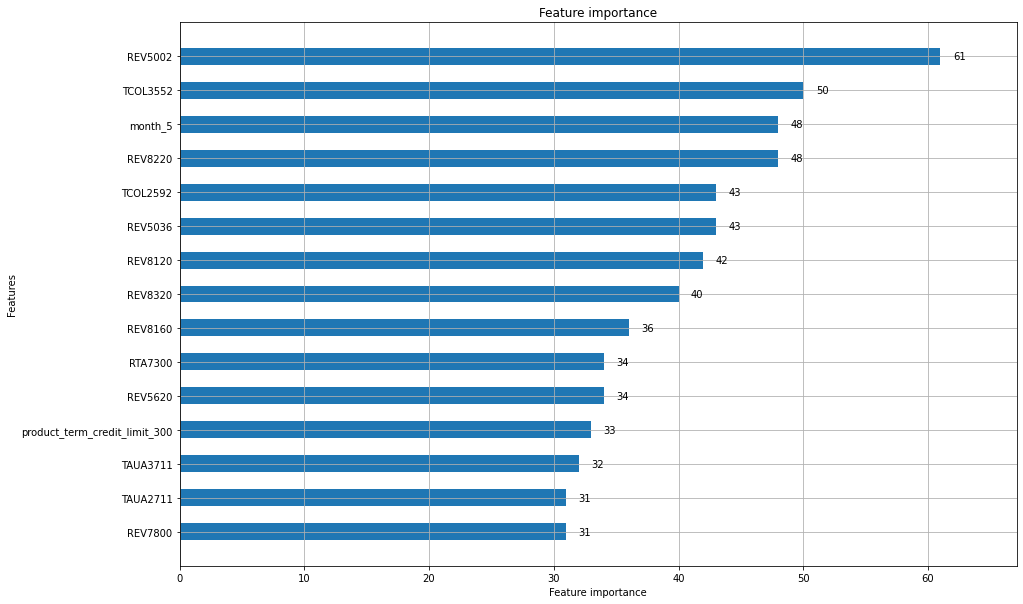

In [22]:
lightgbm_feature_plot(float_df, df['NP'], 'LightGBM Float Feature Importance')


[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113363
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 1466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


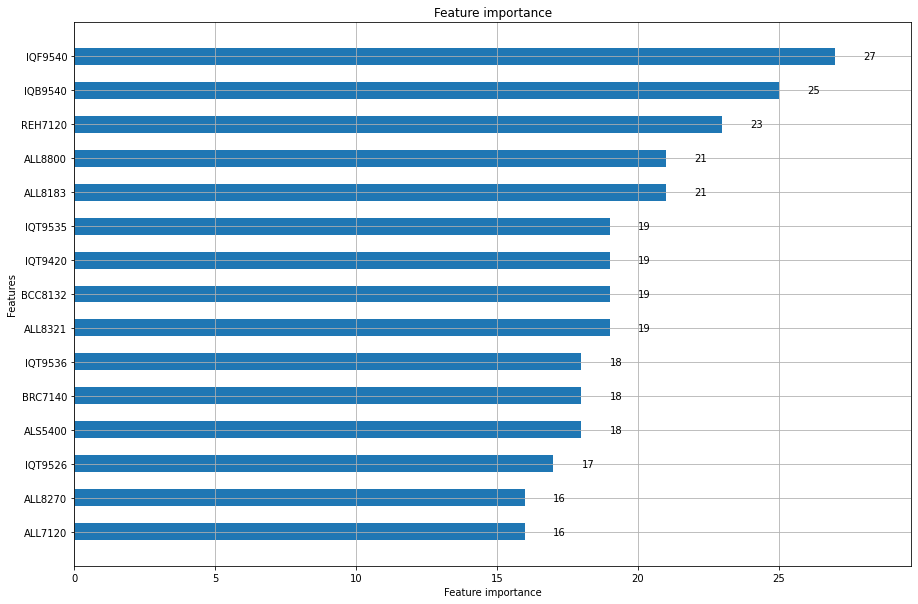

In [23]:
lightgbm_feature_plot(integer_df, df['NP'],'LightGBM Integer Feature Importance')

[LightGBM] [Info] Number of positive: 1725, number of negative: 17305
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 19030, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090646 -> initscore=-2.305768
[LightGBM] [Info] Start training from score -2.305768


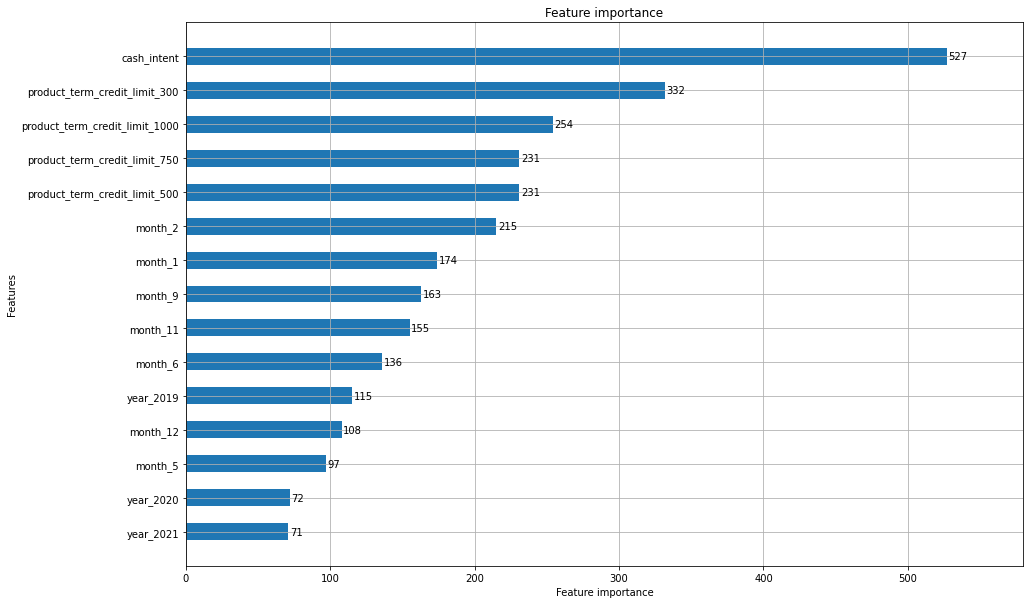

In [24]:
lightgbm_feature_plot(X_encoded, df['NP'], 'LightGBM Categorical Feature Importance')

In [25]:
scaler = preprocessing.StandardScaler()
normalized_integer_df = pd.DataFrame(scaler.fit_transform(integer_df))

float_df.fillna(method='bfill', inplace=True)
normalized_float_df = pd.DataFrame(scaler.fit_transform(float_df))

In [26]:
normalized_integer_df.columns = integer_df.columns

In [27]:
normalized_float_df.columns = float_df.columns

In [28]:
X_final = pd.concat([normalized_float_df, normalized_integer_df, X_encoded, X_pca], axis=1)
X_final.shape

(19031, 2064)

In [29]:
df2 = X_final.iloc[:-1 , :]
df2.shape

(19030, 2064)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df2, df['NP'], test_size=0.1, random_state=42)

In [31]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [32]:
train.shape

(18819, 2065)

In [33]:
train.to_csv('credit-risk-train.csv', sep=',')
valid.to_csv('credit-risk-valid.csv', sep=',')